In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from cycler import cycler
import scipy.stats as stats

In [2]:
df = pd.read_csv('iso.csv')

# Spearman Correlations of Process Products

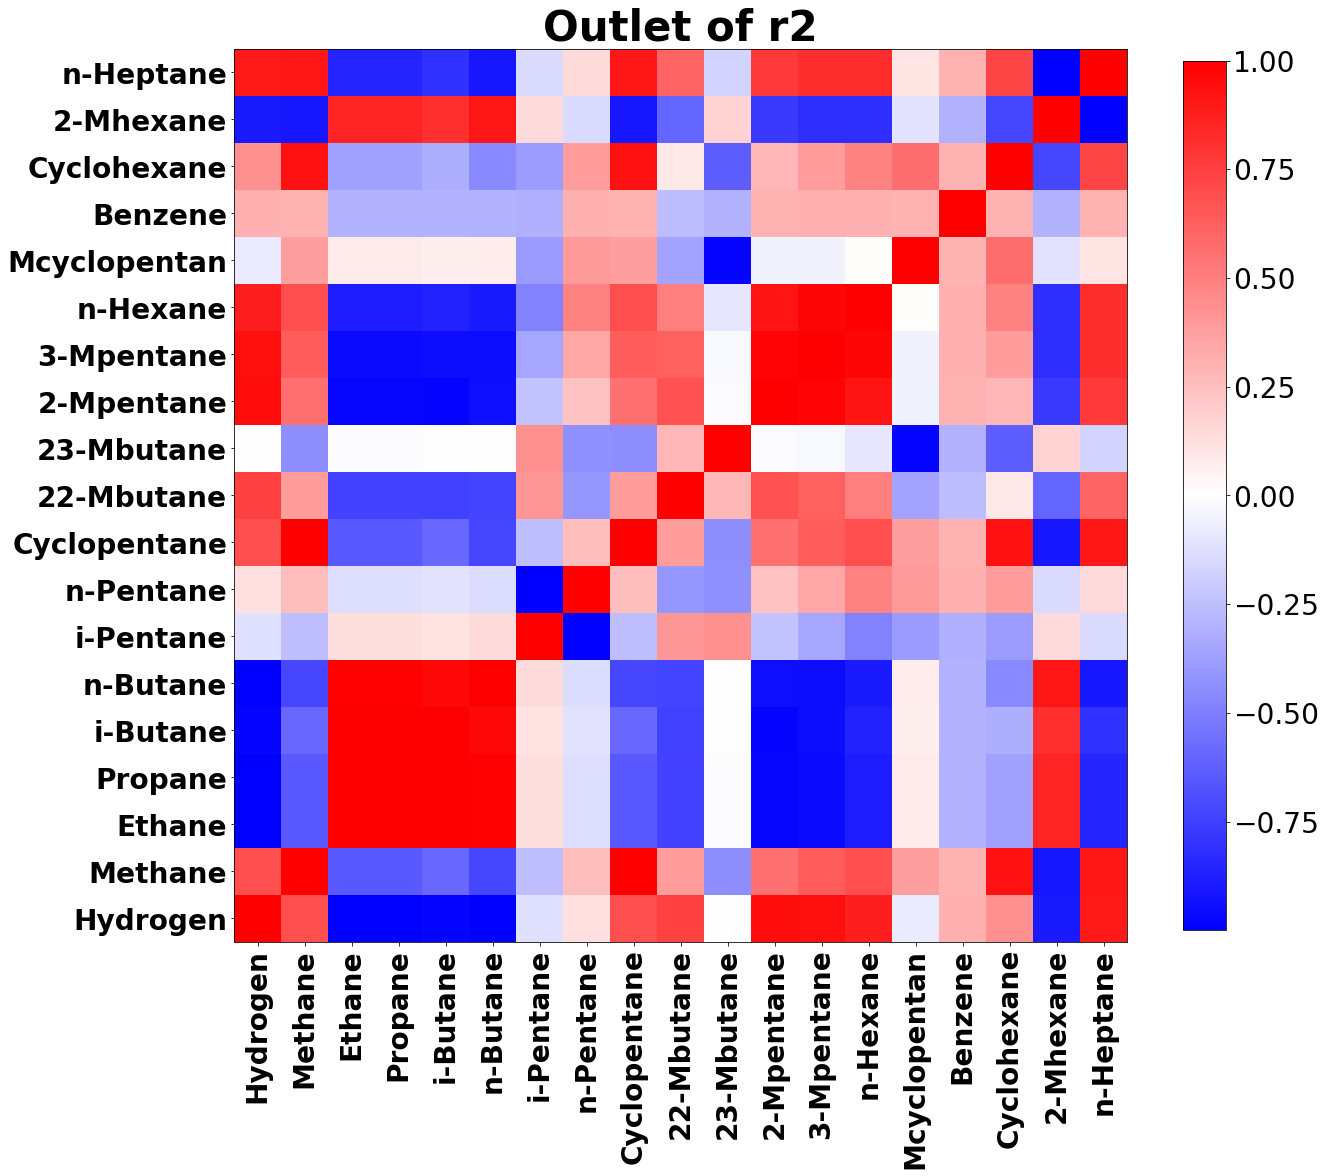

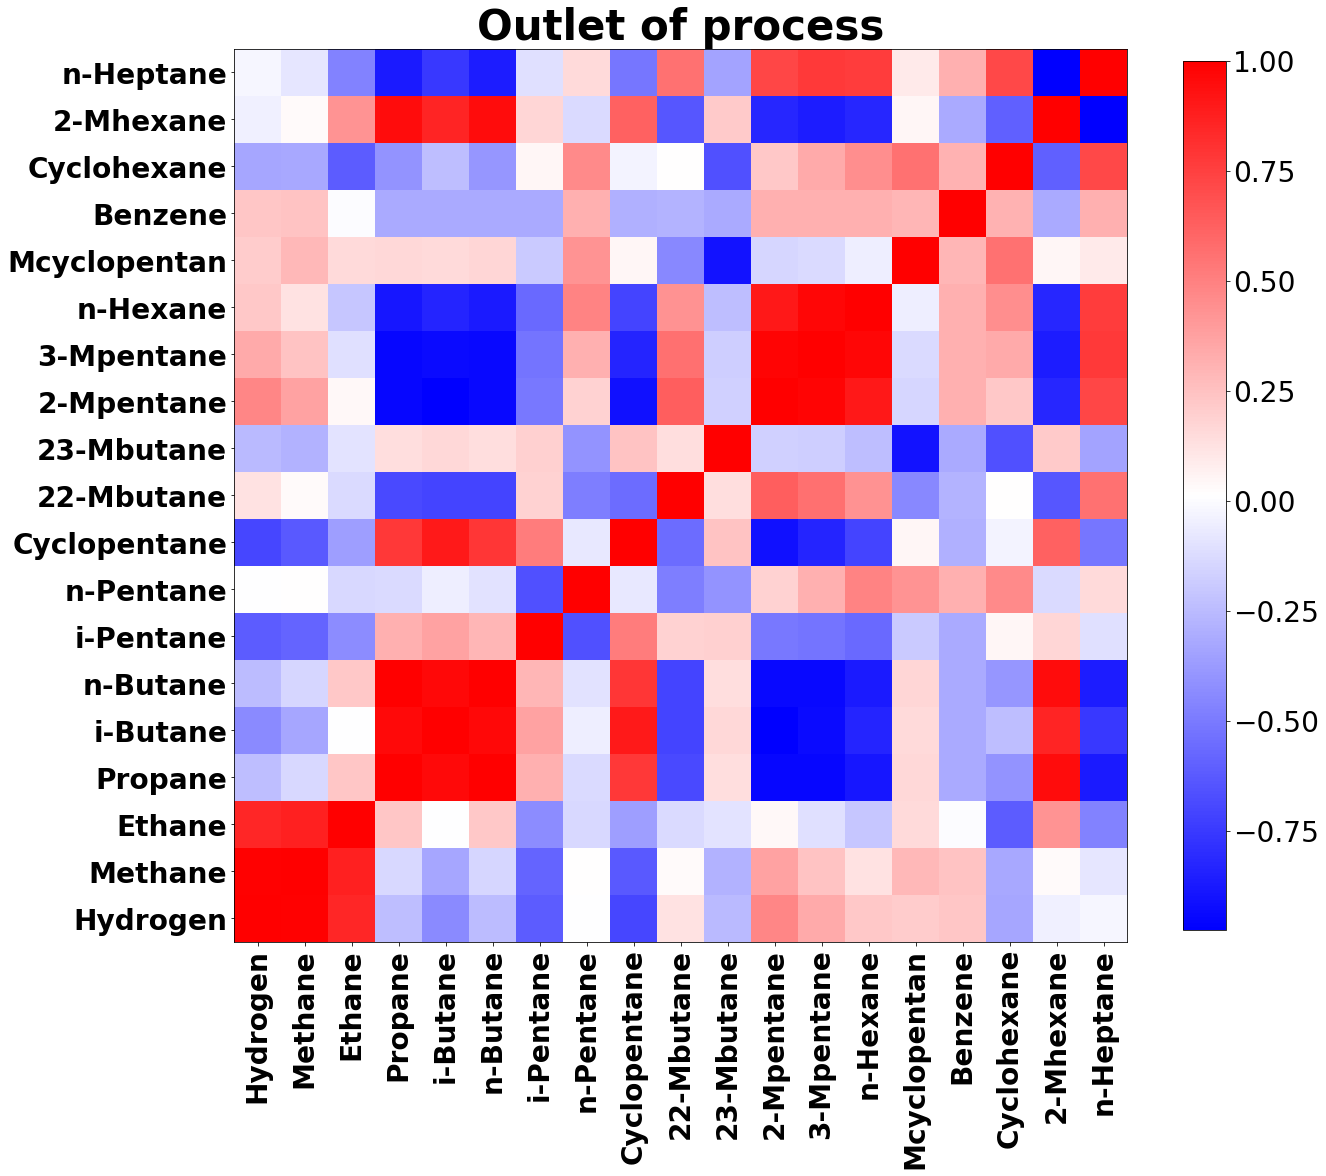

In [26]:
product_cols = [
"Hydrogen",
"Methane",
"Ethane",
"Propane",
"i-Butane",
"n-Butane",
"i-Pentane", 
"n-Pentane",
"Cyclopentane",
"22-Mbutane",
"23-Mbutane",
"2-Mpentane",
"3-Mpentane",
"n-Hexane",
"Mcyclopentan",
"Benzene",
"Cyclohexane",
"2-Mhexane",
"n-Heptane"]

for outlet in ['r2', 'process']:
    actual_cols = ["%s_%s" % (outlet, c) for c in product_cols]
    
    corr_mat = df[actual_cols].corr('spearman')
    n = len(actual_cols)

    f, ax = plt.subplots(1, 1, figsize=(20, 20))
    im = ax.imshow(corr_mat, origin='lower', cmap='bwr')
    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(product_cols, rotation=90, fontsize=28, fontweight='bold')
    ax.set_yticks(np.arange(n))
    ax.set_yticklabels(product_cols, fontsize=28, fontweight='bold')
    cbar = f.colorbar(im, ax=ax, shrink=0.8)
    cbar.ax.tick_params(labelsize=28) 
    ax.set_title("Outlet of %s" % outlet, fontsize=42, fontweight='bold')

# Globally optimize targets

In [16]:
target_cols = ['r2_ron', 'r2_pin', 'r2_c4yield', 'r2_c5yield', 'r1_charge_heater', 'process_ron', 'process_yield']
target_modes = [np.argmax, np.argmax, np.argmax, np.argmax, np.argmin, np.argmax, np.argmax]

monitored_cols = target_cols + ['r1_temp', 'r1_pressure', 'r2_temp', 'r2_pressure']

ffdf = df[df['r1_charge_heater'] >= 0]

ixs = []
for target_col, target_mode in zip(target_cols, target_modes):
    ix_best = target_mode(ffdf[target_col])
    ixs.append(ix_best)

global_sol = ffdf.iloc[ixs][monitored_cols].copy()
global_sol.index = target_cols
global_sol.index.rename('optimization target', inplace=True)
global_sol['optimization mode'] = [tm.__name__.replace('arg','') for tm in target_modes]
global_sol = global_sol[['optimization mode'] + list(global_sol.columns)[:-1]]
global_sol

,optimization mode,r2_ron,r2_pin,r2_c4yield,r2_c5yield,r1_charge_heater,process_ron,process_yield,r1_temp,r1_pressure,r2_temp,r2_pressure
optimization target,,,,,,,,,,,,
r2_ron,max,84.666644,136.700585,0.024689,0.070684,3.443284e+06,84.333626,96.210143,166.0,50.0,146.0,70.0
r2_pin,max,83.886687,136.795042,0.073689,0.210933,4.176121e+06,83.422255,98.350487,148.0,50.0,144.0,90.0
r2_c4yield,max,83.511172,132.291606,0.671690,1.777076,1.134940e+07,83.375936,96.788835,148.0,90.0,166.0,50.0
r2_c5yield,max,83.511172,132.291606,0.671690,1.777076,1.134940e+07,83.375936,96.788835,148.0,90.0,166.0,50.0
r1_charge_heater,min,84.189062,134.191270,0.008470,0.026688,6.969533e+02,83.733951,96.816773,162.0,90.0,134.0,90.0
process_ron,max,84.611823,136.182769,0.044744,0.125438,5.289324e+06,84.399594,95.958417,166.0,50.0,152.0,90.0
process_yield,max,76.919326,101.362343,0.018302,0.086894,5.977331e+06,77.084749,100.294469,128.0,90.0,128.0,90.0


In [17]:
global_sol.to_excel("tmp/global_optima.xlsx")

# Plot optimization landscape of targets as a function of the four process parameters

Text(0.5, 0.98, 'Effect on Process RON')

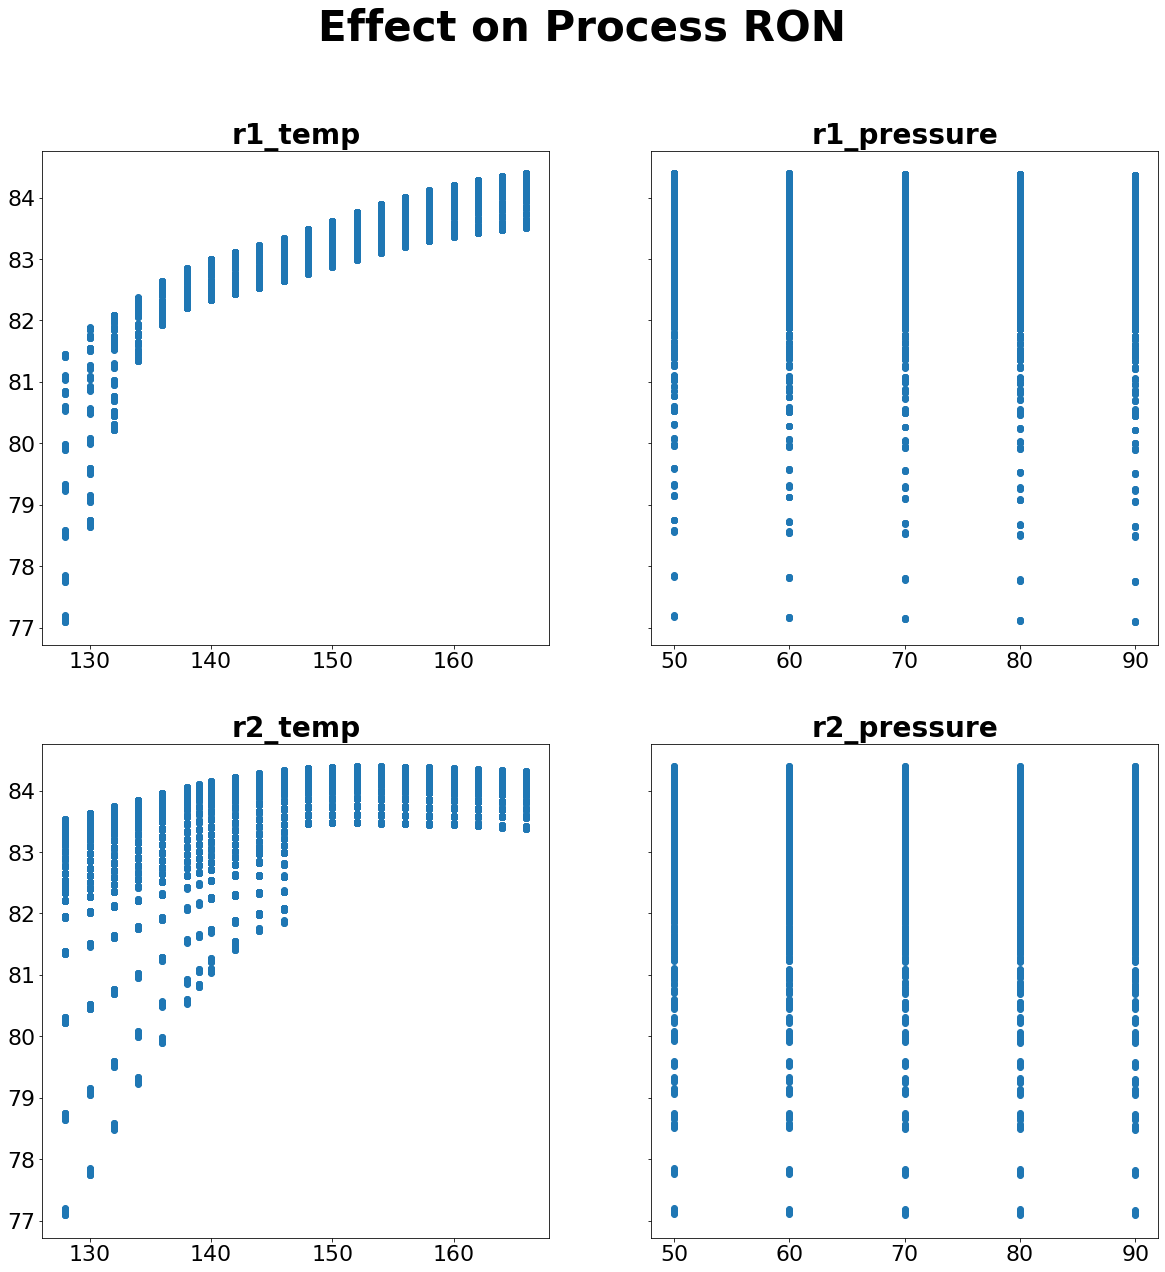

In [39]:
dependent_var = 'process_ron'
independent_vars = ['r1_temp', 'r1_pressure', 'r2_temp', 'r2_pressure']

f, axes = plt.subplots(2, 2, figsize=(20, 20), sharey=True)
axes = axes.flatten()
for i, iv in enumerate(independent_vars):
    ax = axes[i]
    ax.plot(df[iv], df[dependent_var], 'o')
    ax.set_title(iv, fontsize=28, fontweight='bold')
    ax.tick_params(axis='x', labelsize=22)
    ax.tick_params(axis='y', labelsize=22)
f.suptitle('Effect on Process RON', fontsize=42, fontweight='bold')

Text(0.5, 0.98, 'Effect on Process Yield')

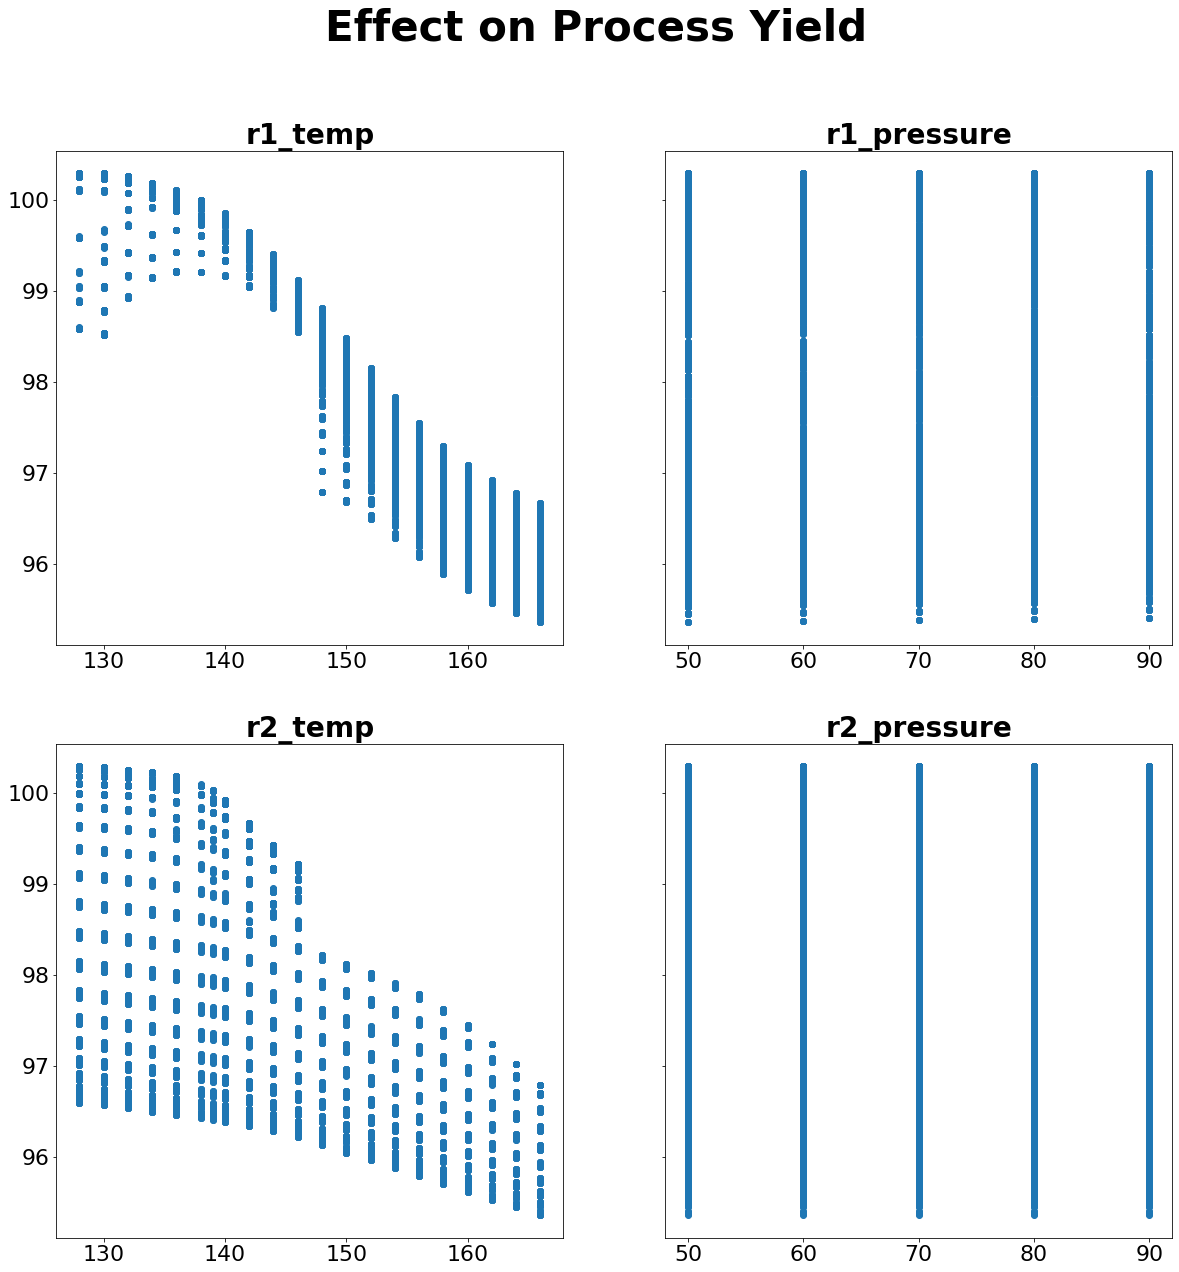

In [38]:
dependent_var = 'process_yield'
independent_vars = ['r1_temp', 'r1_pressure', 'r2_temp', 'r2_pressure']

f, axes = plt.subplots(2, 2, figsize=(20, 20), sharey=True)
axes = axes.flatten()
for i, iv in enumerate(independent_vars):
    ax = axes[i]
    ax.plot(df[iv], df[dependent_var], 'o')
    ax.set_title(iv, fontsize=28, fontweight='bold')
    ax.tick_params(axis='x', labelsize=22)
    ax.tick_params(axis='y', labelsize=22)
f.suptitle('Effect on Process Yield', fontsize=42, fontweight='bold')

# Effect of R1 and R2 on Process RON

Text(0.5, 1.0, 'Effect of Reactor \n Temperatures on Process RON')

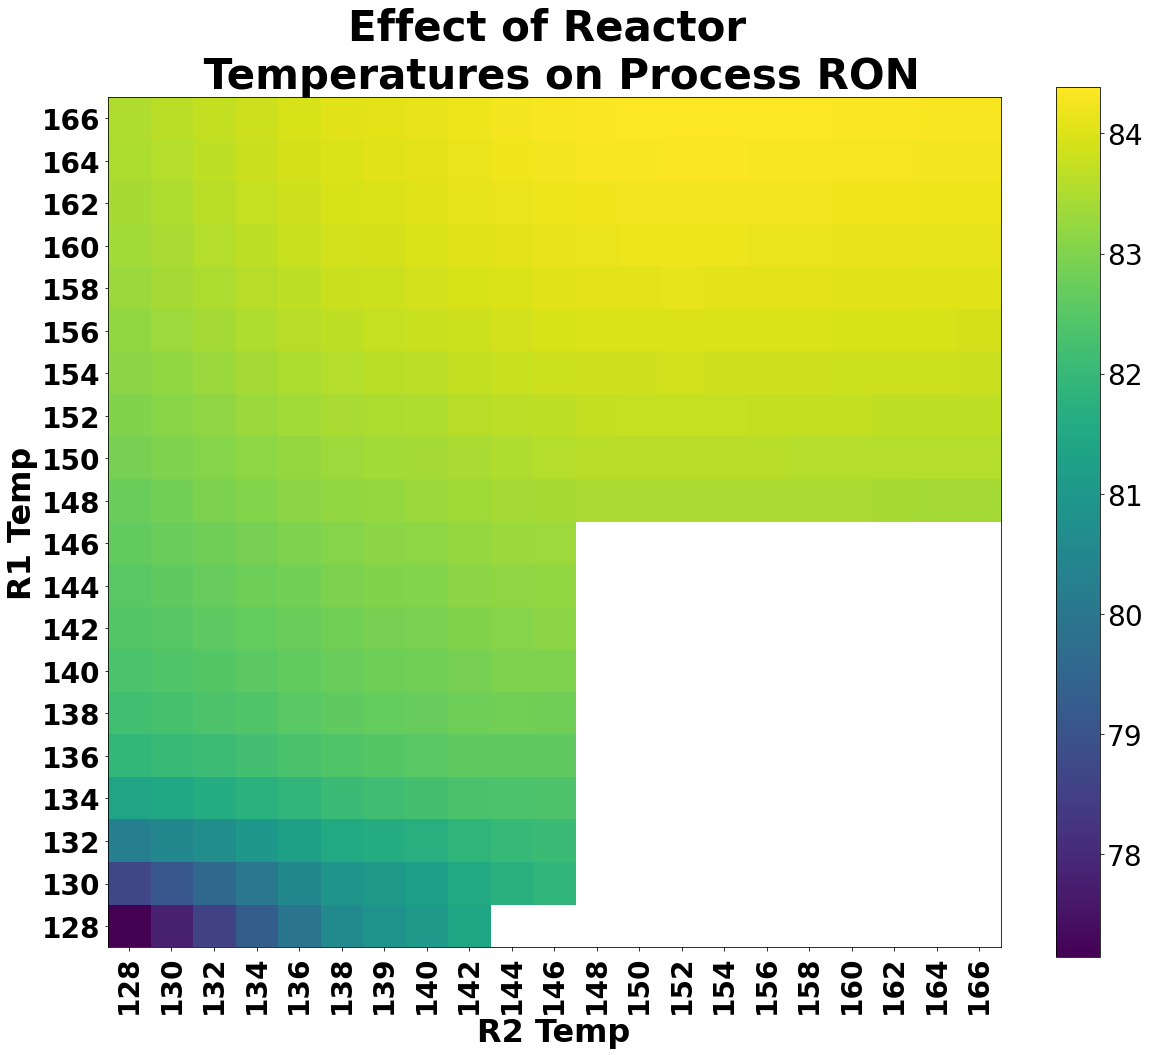

In [64]:
r1s = sorted(set(df['r1_temp']))
r2s = sorted(set(df['r2_temp']))
dependent_var = 'process_ron'

M = np.zeros((len(r1s), len(r2s)))
for i, r1t in enumerate(r1s):
    for j, r2t in enumerate(r2s):
        sdf = df[(df['r1_temp'] == r1t) & (df['r2_temp'] == r2t)]
        mean_dep = np.mean(sdf[dependent_var])
        M[i, j] = mean_dep

n,m = M.shape

f, ax = plt.subplots(1, 1, figsize=(20, 20))
im = ax.imshow(M, origin='lower')
ax.set_xticks(np.arange(m))
ax.set_xticklabels(['%d' % d for d in r2s], rotation=90, fontsize=28, fontweight='bold')
ax.set_yticks(np.arange(n))
ax.set_yticklabels(['%d' % d for d in r1s], fontsize=28, fontweight='bold')
ax.set_xlabel('R2 Temp', fontsize=32, fontweight='bold')
ax.set_ylabel('R1 Temp', fontsize=32, fontweight='bold')
cbar = f.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=28) 
ax.set_title('Effect of Reactor \n Temperatures on Process RON', fontsize=42, fontweight='bold')

Text(0.5, 1.0, 'Effect of Reactor \n Temperatures on Process Yield')

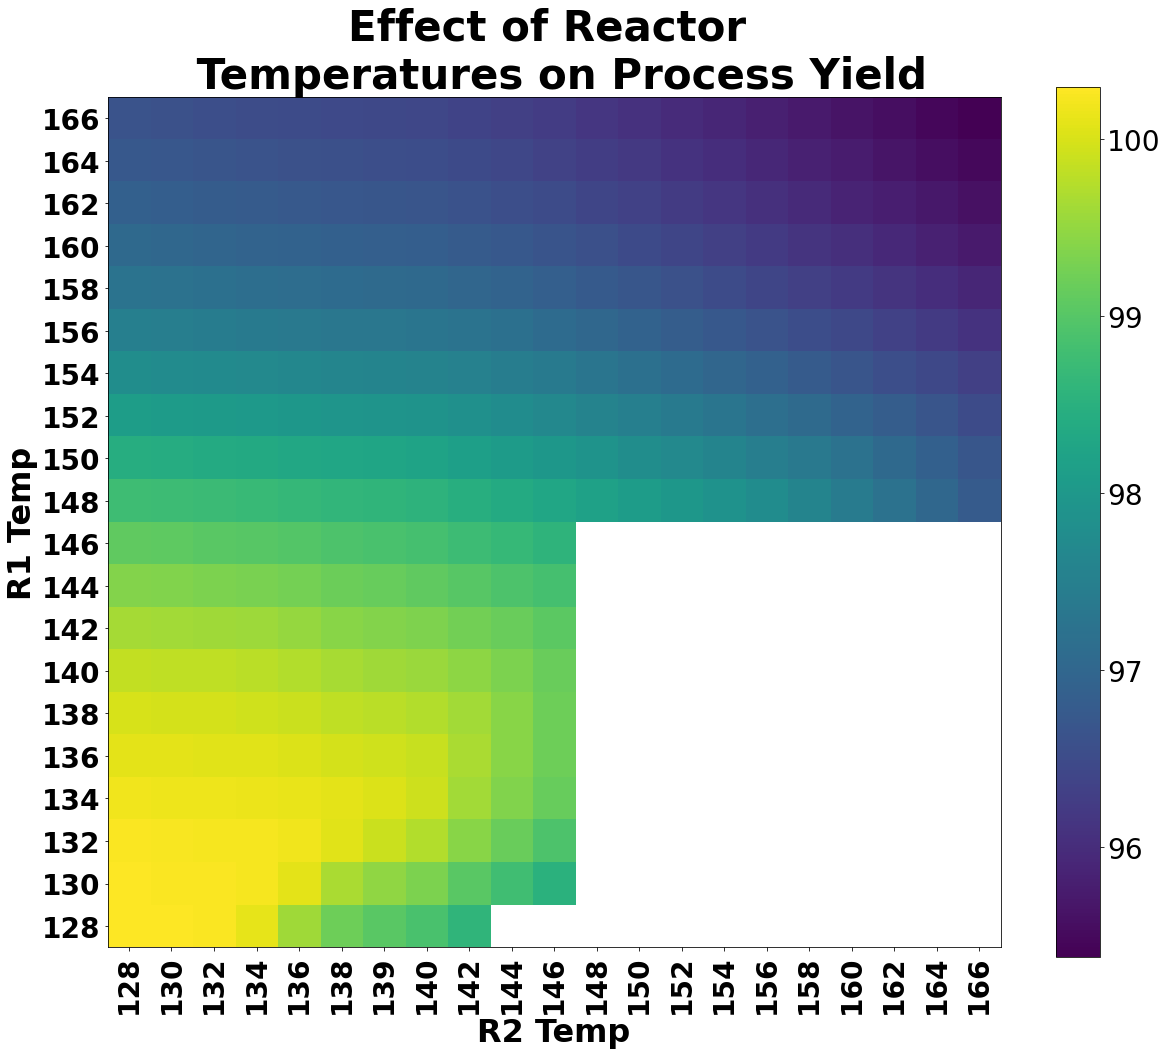

In [66]:
r1s = sorted(set(df['r1_temp']))
r2s = sorted(set(df['r2_temp']))
dependent_var = 'process_yield'

M = np.zeros((len(r1s), len(r2s)))
for i, r1t in enumerate(r1s):
    for j, r2t in enumerate(r2s):
        sdf = df[(df['r1_temp'] == r1t) & (df['r2_temp'] == r2t)]
        mean_dep = np.mean(sdf[dependent_var])
        M[i, j] = mean_dep

n,m = M.shape

f, ax = plt.subplots(1, 1, figsize=(20, 20))
im = ax.imshow(M, origin='lower')
ax.set_xticks(np.arange(m))
ax.set_xticklabels(['%d' % d for d in r2s], rotation=90, fontsize=28, fontweight='bold')
ax.set_yticks(np.arange(n))
ax.set_yticklabels(['%d' % d for d in r1s], fontsize=28, fontweight='bold')
ax.set_xlabel('R2 Temp', fontsize=32, fontweight='bold')
ax.set_ylabel('R1 Temp', fontsize=32, fontweight='bold')
cbar = f.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=28) 
ax.set_title('Effect of Reactor \n Temperatures on Process Yield', fontsize=42, fontweight='bold')

Text(0.5, 1.0, 'Effect of Reactor \n Temperatures on Charge Heater')

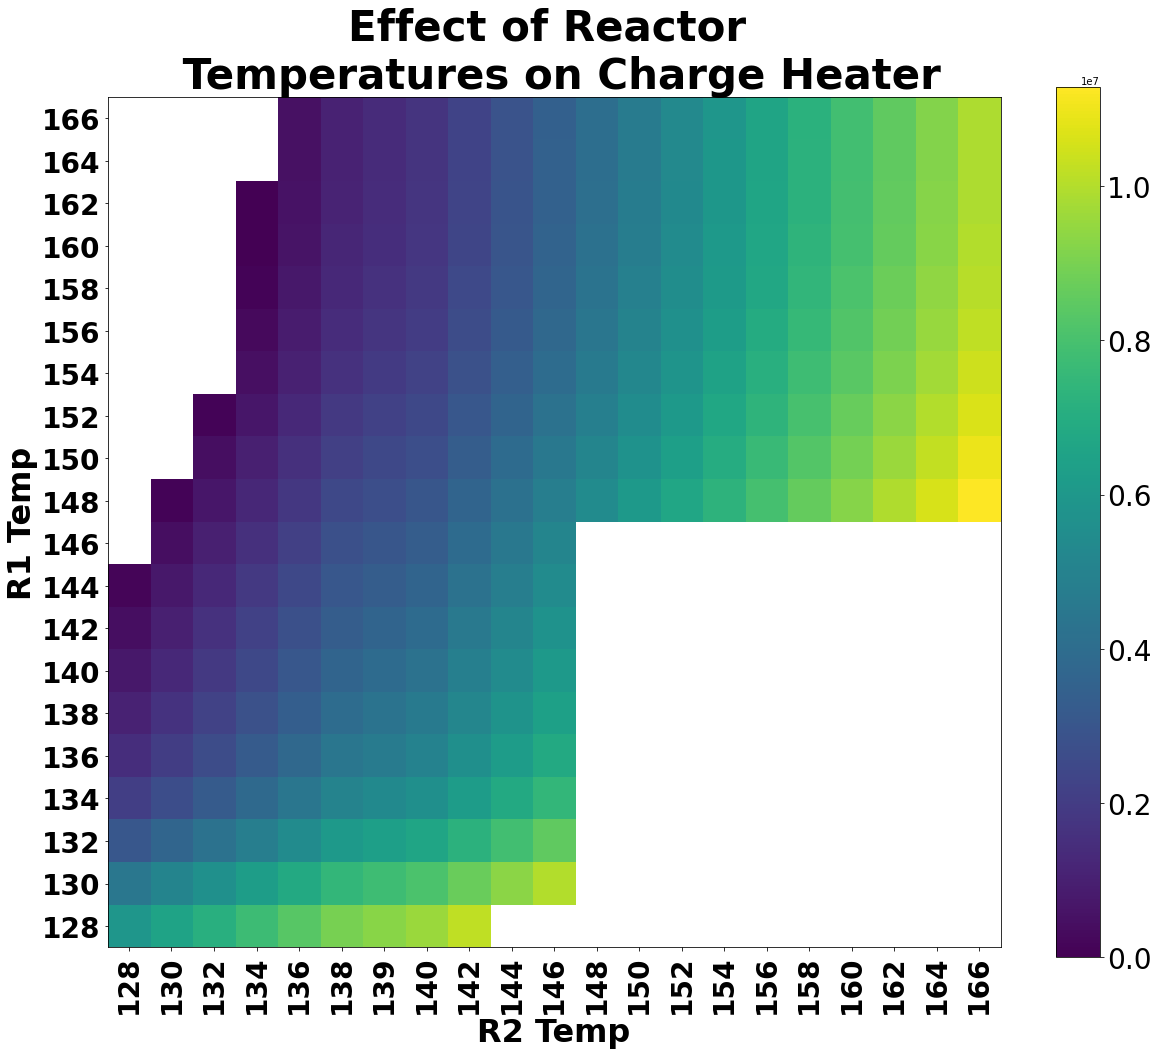

In [134]:
r1s = sorted(set(df['r1_temp']))
r2s = sorted(set(df['r2_temp']))
dependent_var = 'r1_charge_heater'

M = np.zeros((len(r1s), len(r2s)))
for i, r1t in enumerate(r1s):
    for j, r2t in enumerate(r2s):
        sdf = df[(df['r1_temp'] == r1t) & (df['r2_temp'] == r2t) & (df['r1_charge_heater'] >= 0)]
        mean_dep = np.mean(sdf[dependent_var])
        M[i, j] = mean_dep

n,m = M.shape

f, ax = plt.subplots(1, 1, figsize=(20, 20))
im = ax.imshow(M, origin='lower', vmin=0)
ax.set_xticks(np.arange(m))
ax.set_xticklabels(['%d' % d for d in r2s], rotation=90, fontsize=28, fontweight='bold')
ax.set_yticks(np.arange(n))
ax.set_yticklabels(['%d' % d for d in r1s], fontsize=28, fontweight='bold')
ax.set_xlabel('R2 Temp', fontsize=32, fontweight='bold')
ax.set_ylabel('R1 Temp', fontsize=32, fontweight='bold')
cbar = f.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=28) 
ax.set_title('Effect of Reactor \n Temperatures on Charge Heater', fontsize=42, fontweight='bold')

# Constrained Optimization of Charge Heater

In [111]:
# % less than maximum RON
thres_ron = [0.01, 0.02, 0.05, 0.1]

# % less than maximum yield
thres_yield = [0.01, 0.02, 0.05, 0.1]

max_ron = np.max(ffdf['process_ron'])
max_yield = np.max(ffdf['process_yield'])

results = []
for tron in thres_ron:
    min_ron = max_ron * (1-tron)
    
    for tyield in thres_yield:
        min_yield = max_yield * (1-tyield)
        
        ix = (ffdf['process_ron'] >= min_ron) & (ffdf['process_yield'] >= min_yield)
        
        if np.sum(ix) > 0:
            sdf = ffdf[ix]
            
            best_ix = np.argmin(sdf['r1_charge_heater'])
            best_index = sdf.index[best_ix]
            
            results.append((tron, tyield, best_index)) 
results = np.array(results)

In [114]:
constrained_sol = ffdf.loc[results[:,2]][monitored_cols].copy()
constrained_sol['% of max ron'] = (1 - results[:,0]) * 100
constrained_sol['% of max yield'] = (1 - results[:,1]) * 100
constrained_sol['min ron'] = max_ron * (1-results[:,0])
constrained_sol['min yield'] = max_yield * (1-results[:,1])
constrained_sol

,r2_ron,r2_pin,r2_c4yield,r2_c5yield,r1_charge_heater,process_ron,process_yield,r1_temp,r1_pressure,r2_temp,r2_pressure,% of max ron,% of max yield,min ron,min yield
5563.0,84.189062,134.191270,0.008470,0.026688,6.969533e+02,83.733951,96.816773,162.0,90.0,134.0,90.0,99.0,95.0,83.555598,95.279745
5563.0,84.189062,134.191270,0.008470,0.026688,6.969533e+02,83.733951,96.816773,162.0,90.0,134.0,90.0,99.0,90.0,83.555598,90.265022
3226.0,83.326452,135.450916,0.021956,0.072002,1.857594e+06,82.780409,99.292853,144.0,60.0,134.0,70.0,98.0,99.0,82.711603,99.291524
2737.0,83.449230,134.210811,0.011360,0.040537,8.196240e+04,82.871260,98.715848,148.0,50.0,130.0,70.0,98.0,98.0,82.711603,98.288579
5563.0,84.189062,134.191270,0.008470,0.026688,6.969533e+02,83.733951,96.816773,162.0,90.0,134.0,90.0,98.0,95.0,82.711603,95.279745
5563.0,84.189062,134.191270,0.008470,0.026688,6.969533e+02,83.733951,96.816773,162.0,90.0,134.0,90.0,98.0,90.0,82.711603,90.265022
3429.0,83.107351,134.016132,0.008096,0.032797,1.166045e+05,82.549463,99.360533,144.0,50.0,128.0,70.0,95.0,99.0,80.179615,99.291524
2737.0,83.449230,134.210811,0.011360,0.040537,8.196240e+04,82.871260,98.715848,148.0,50.0,130.0,70.0,95.0,98.0,80.179615,98.288579
5563.0,84.189062,134.191270,0.008470,0.026688,6.969533e+02,83.733951,96.816773,162.0,90.0,134.0,90.0,95.0,95.0,80.179615,95.279745
5563.0,84.189062,134.191270,0.008470,0.026688,6.969533e+02,83.733951,96.816773,162.0,90.0,134.0,90.0,95.0,90.0,80.179615,90.265022


Text(0.5, 1.0, 'Effect of Reactor \n Temperatures on Charge Heater')

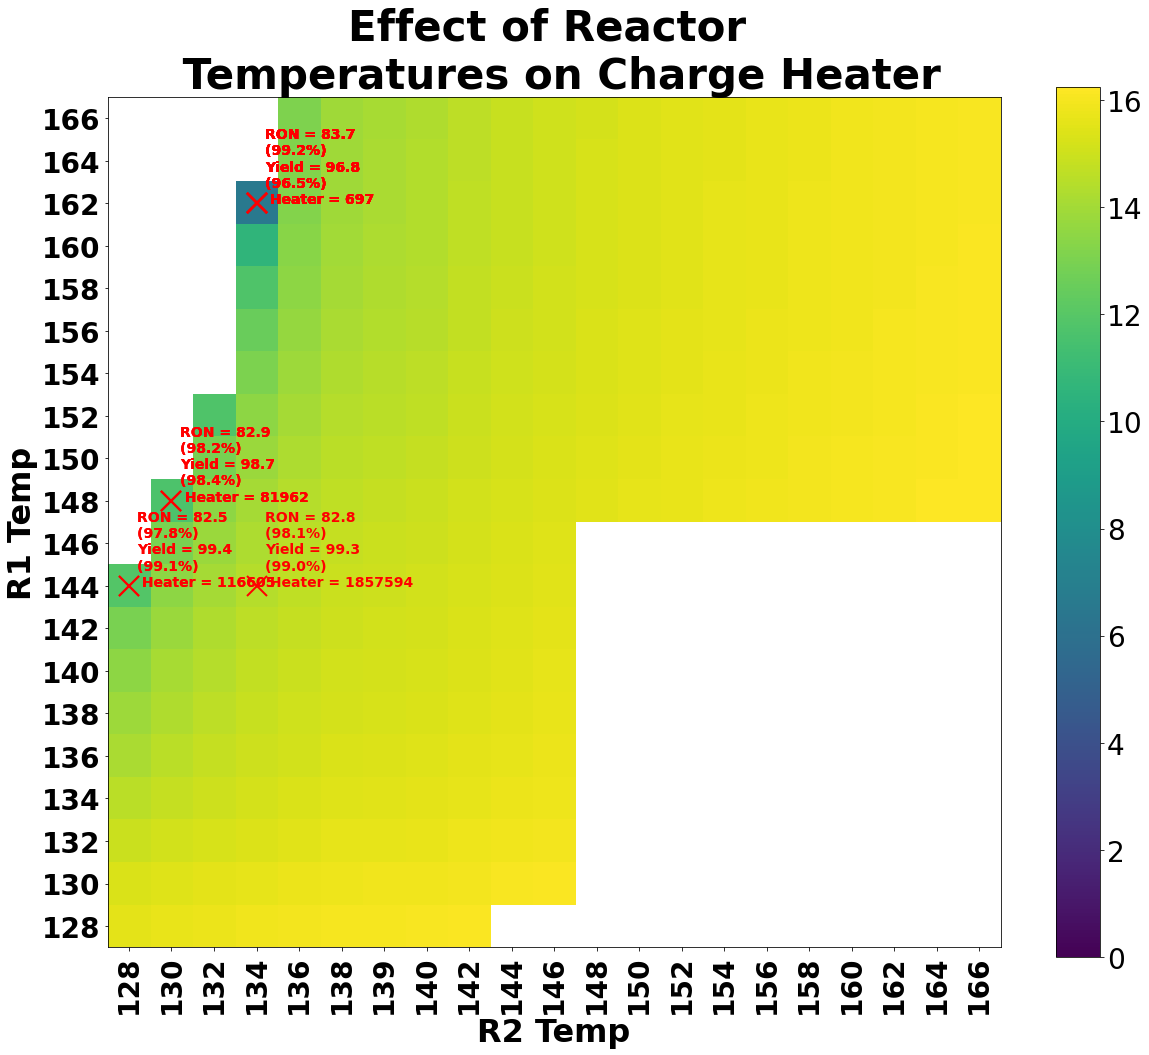

In [143]:
r1s = sorted(set(df['r1_temp']))
r1idxs = dict(zip(r1s, range(len(r1s))))
r2s = sorted(set(df['r2_temp']))
r2idxs = dict(zip(r2s, range(len(r2s))))
dependent_var = 'r1_charge_heater'

M = np.zeros((len(r1s), len(r2s)))
for i, r1t in enumerate(r1s):
    for j, r2t in enumerate(r2s):
        sdf = df[(df['r1_temp'] == r1t) & (df['r2_temp'] == r2t) & (df['r1_charge_heater'] >= 0)]
        mean_dep = np.mean(sdf[dependent_var])
        M[i, j] = mean_dep

n,m = M.shape
f, ax = plt.subplots(1, 1, figsize=(20, 20))
im = ax.imshow(np.log(M), origin='lower', vmin=0)

for r in constrained_sol.itertuples():
    r1idx = r1idxs[r.r1_temp]
    r2idx = r2idxs[r.r2_temp]
    ax.plot([r2idx], [r1idx], 'x', markersize=20, color='red', markeredgewidth=2)
    ax.annotate('RON = %4.1f\n(%4.1f%%) \nYield = %4.1f \n(%4.1f%%) \n Heater = %.0f ' % (r.process_ron, 
                                                                                r.process_ron * 100 / max_ron, 
                                                                                r.process_yield,
                                                                                r.process_yield * 100 / max_yield,
                                                                                r.r1_charge_heater), 
            (r2idx, r1idx), (r2idx+0.2, r1idx), fontsize=14, color='red', fontweight='bold')
    
ax.set_xticks(np.arange(m))
ax.set_xticklabels(['%d' % d for d in r2s], rotation=90, fontsize=28, fontweight='bold')
ax.set_yticks(np.arange(n))
ax.set_yticklabels(['%d' % d for d in r1s], fontsize=28, fontweight='bold')
ax.set_xlabel('R2 Temp', fontsize=32, fontweight='bold')
ax.set_ylabel('R1 Temp', fontsize=32, fontweight='bold')
cbar = f.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=28) 
ax.set_title('Effect of Reactor \n Temperatures on Charge Heater', fontsize=42, fontweight='bold')

140.000000,146.000000
142.000000,142.000000
142.000000,144.000000
142.000000,146.000000
144.000000,139.000000
144.000000,140.000000
144.000000,142.000000
144.000000,144.000000
144.000000,146.000000
146.000000,136.000000
146.000000,138.000000
146.000000,139.000000
146.000000,140.000000
146.000000,142.000000
146.000000,144.000000
146.000000,146.000000
148.000000,134.000000
148.000000,136.000000
148.000000,138.000000
148.000000,139.000000
148.000000,140.000000
148.000000,142.000000
148.000000,144.000000
148.000000,146.000000
148.000000,148.000000
148.000000,150.000000
148.000000,152.000000
150.000000,132.000000
150.000000,134.000000
150.000000,136.000000
150.000000,138.000000
150.000000,139.000000
150.000000,140.000000
150.000000,142.000000
150.000000,144.000000
150.000000,146.000000
152.000000,132.000000
152.000000,134.000000
152.000000,136.000000


Text(0.5, 1.0, 'Effect of Reactor \n Temperatures on Charge Heater')

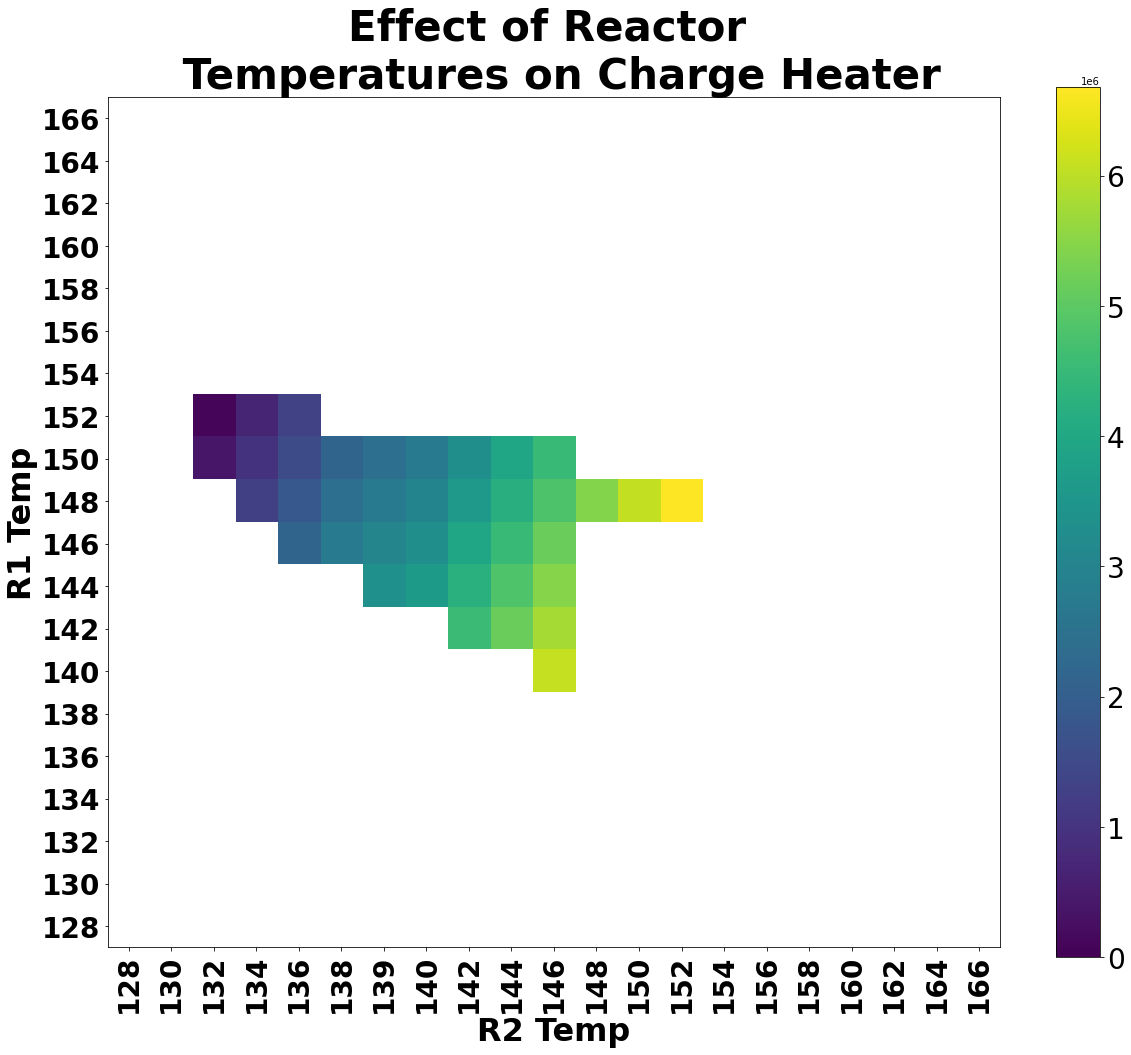

In [5]:
r1s = sorted(set(df['r1_temp']))
r1idxs = dict(zip(r1s, range(len(r1s))))
r2s = sorted(set(df['r2_temp']))
r2idxs = dict(zip(r2s, range(len(r2s))))
dependent_var = 'r1_charge_heater'

yield_var = 'process_yield'
ron_var = 'process_ron'
min_yield = 98
min_ron = 83

M = np.zeros((len(r1s), len(r2s)))
for i, r1t in enumerate(r1s):
    for j, r2t in enumerate(r2s):
        sdf = df[(df['r1_temp'] == r1t) & (df['r2_temp'] == r2t) & (df['r1_charge_heater'] >= 0)]
        mean_dep = np.mean(sdf[dependent_var])
        yields = sdf[yield_var]
        rons = sdf[ron_var]
        
        if np.any((yields >= min_yield) & (rons >= min_ron)):
            print("%f,%f" % (r1t,r2t))
            M[i, j] = mean_dep
        else:
            M[i, j] = np.nan

n,m = M.shape
f, ax = plt.subplots(1, 1, figsize=(20, 20))
im = ax.imshow(M, origin='lower', vmin=0)

ax.set_xticks(np.arange(m))
ax.set_xticklabels(['%d' % d for d in r2s], rotation=90, fontsize=28, fontweight='bold')
ax.set_yticks(np.arange(n))
ax.set_yticklabels(['%d' % d for d in r1s], fontsize=28, fontweight='bold')
ax.set_xlabel('R2 Temp', fontsize=32, fontweight='bold')
ax.set_ylabel('R1 Temp', fontsize=32, fontweight='bold')
cbar = f.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=28) 
ax.set_title('Effect of Reactor \n Temperatures on Charge Heater', fontsize=42, fontweight='bold')